# **EECS598-012: Unsupervised Visual Learning**

Before we start, please put your name and UMID in the following format

: Firstname LASTNAME, #00000000   //   e.g.) Andrew OWENS, #12345678

**Your Answer:**   


#**Variational Autoencoders**
In this notebook, we'll learn how to build and train a simple VAE model and a VQ-VAE model


The following papers might help you understand the models better. 

- [Carl Deorsch. Tutorial on Variational Autoencoders](https://arxiv.org/pdf/1606.05908.pdf)

- [Aaron van den Oord, et al. Neural Discrete Representation Learning](https://arxiv.org/pdf/1711.00937.pdf)

The problem set is **due** on **Apr. 21**.

**Acknowledgement:** This notebook is based on the assignment of EECS 498-007 / 598-005 given by Justin Johnson and CS294-158-SP20 given by Pieter Abbeel, Peter Chen, Jonathan Ho and Aravind Srinivas.

We'll use Google Colab to do the homework. You'll write the code in the *.py files, and run the model in this notebook. Colab provides GPU resources, and it's also fine to use your local machine.

You'll be required to upload your notebook code and *.py code to Gradescope as a *.zip file. 

## Setup Code

Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

- Check whether you have access to **GPU** resources on Colab. Go to **Runtime -> Change runtime type** and make sure you have selected **GPU** as the hardware accelerator. 
- Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['.ipynb_checkpoints', 'utils', 'models', 'imgs', 'data', 'vae.ipynb', 'bigan.ipynb', 'pixel_cnn.ipynb', 'av_loc.ipynb']
```

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A5 folder, then '2020FA/A5'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'EECS598-012-ProblemSets_s'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['models', '.ipynb_checkpoints', 'utils', 'dataset', 'av_loc.ipynb', 'pixel_cnn.ipynb', 'vae.ipynb', 'bigan.ipynb']


In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

In [ ]:
import torch

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import utils


### Dataset

We'll train a simple VAE model on CIFAR datasets. Execute the cell below to visualize the CIFAR dataset. 

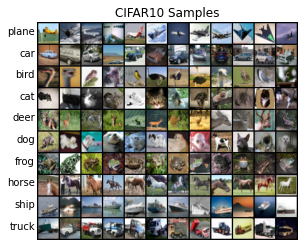

Train data shape:  (50000, 3, 32, 32)
Test data shape:  (10000, 3, 32, 32)


In [ ]:
data_dict = utils.preprocess_cifar10(show_examples=True)
# images has been normalized to [0,1]
print('Train data shape: ', data_dict['X_train'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
train_data = data_dict['X_train']
test_data = data_dict['X_test']


In [ ]:
print(train_data.shape, train_data.min(), train_data.max())
print(test_data.shape, test_data.min(), test_data.max())

(50000, 3, 32, 32) 0.0 1.0
(10000, 3, 32, 32) 0.0 1.0


## Q1: VAE



In this part, you'll implement a simple VAE model, and use the CIFAR10 dataset to train the model. 

### Loss Function

We'll first take a look at the loss function for the VAE model. As seen below, the loss function for VAEs contains two terms: A reconstruction loss term (left) and a KL divergence term (right). 

$$-E_{z \sim q_{\phi}(z|x)}[log p_{\theta}(x|z)] + D_{KL}(q_{\phi}(z|x), p(z)))$$

Note that this is the negative of the variational lower bound shown in the lecture--this ensures that when we are minimizing this loss term, we're maximizing the variational lower bound. The reconstruction loss term can be computed by simply using the binary cross-entropy loss between the original input pixels and the output pixels of our decoder. The KL divergence term works to force the latent space distribution to be close to a prior distribution (we're using a standard normal Gaussian as our prior).

###**Q1.1** 

In practice, we'll use the following losses to optimize the VAE model. **Show that the following terms are equivalent to the reconstruction loss term and KL divergence term.**

- We can optimize the reconstruction loss term $-E_{z\sim q_\phi(z|x)}[\log{p(x|z)}]$
as the MSE loss between original image and reconstructed image. 

- We can optimize the KL divergence term as 

$$D_{KL}(q_{\phi}(z|x), p(z))) = -\frac{1}{2} \sum_{j=1}^{J} (1 + log(\sigma_{z|x}^2)_{j} - (\mu_{z|x})^2_{j} - (\sigma_{z|x})^2_{j}$$




**You answer:** 


### **Q1.2**

In this question, we'll build a simple VAE model. 

We recommend the following network architecture: 

- Notations:   
  covolutional layer: Conv - \$output_dim - \$kernel_size - \$stride - \$padding  
  transposed covolutional layer: TConv - \$output_dim - \$kernel_size - \$stride - \$padding  
  fully connected layer: fc - \$output_dim

- For encoder model:   
  Conv - 32 - 3 - 1 - 1  
  ReLU   
  Conv - 64 - 3 - 2 - 1  
  ReLU   
  Conv - 128 - 3 - 2 - 1  
  ReLU   
  Conv - 256 - 3 - 2 - 1  
  ReLU  
  flatten to (16, )   
  fc - 32  

- For decoder model:   
  fc - 2048  
  ReLU  
  reshape to (4, 4, 128)  
  TConv - 128 - 4 - 2 - 1  
  ReLU  
  TConv - 64 - 4 - 2 - 1  
  ReLU  
  TConv - 32 - 4 - 2 - 1  
  ReLU  
  Conv - 3 - 3 - 1 - 1


We provide the training code in **models/vae_solver.py** and a model template in **models/vae_model.py**. Please follow the instructions and fill in the functions in **models/vae_model.py**. 

We provide the functions for plotting and visualizing images. **You'll provide the following results.**
- Record the average negative ELBO, reconstruction term, and KL term of the training data (per mini-batch) and testing data (per epoch).
- Sample 100 images using the trained model. 
- Original and reconstructed image pairs using the trained VAE model. 
- Interpolation of 10 image pairs, and show 10 samples for each interpolation. 



In [ ]:
from models.vae_solver import train_vae
from utils.vis import show_samples, plot_vae_training_plot

Epoch 0, loss 284.7927, recon_loss 255.5792, kl_loss 29.2135: 100%|██████████| 50000/50000 [00:10<00:00, 4718.12it/s]
Epoch 1, loss 284.5858, recon_loss 254.7569, kl_loss 29.8289:   2%|▏         | 768/50000 [00:00<00:10, 4505.79it/s]

Test , loss 281.6527, recon_loss 252.4470, kl_loss 29.2057


Epoch 1, loss 251.7190, recon_loss 221.2692, kl_loss 30.4498: 100%|██████████| 50000/50000 [00:10<00:00, 4793.83it/s]
Epoch 2, loss 253.4289, recon_loss 223.0082, kl_loss 30.4206:   2%|▏         | 768/50000 [00:00<00:10, 4861.17it/s]

Test , loss 252.4218, recon_loss 223.0729, kl_loss 29.3489


Epoch 2, loss 247.3764, recon_loss 216.9062, kl_loss 30.4702: 100%|██████████| 50000/50000 [00:10<00:00, 4707.38it/s]
Epoch 3, loss 238.7534, recon_loss 207.8845, kl_loss 30.8690:   2%|▏         | 768/50000 [00:00<00:10, 4805.69it/s]

Test , loss 246.6349, recon_loss 215.9431, kl_loss 30.6918


Epoch 3, loss 244.5517, recon_loss 214.0667, kl_loss 30.4850: 100%|██████████| 50000/50000 [00:10<00:00, 4703.28it/s]
Epoch 4, loss 244.5267, recon_loss 213.7126, kl_loss 30.8141:   2%|▏         | 768/50000 [00:00<00:10, 4578.55it/s]

Test , loss 245.4888, recon_loss 215.0621, kl_loss 30.4267


Epoch 4, loss 243.7076, recon_loss 212.9165, kl_loss 30.7911: 100%|██████████| 50000/50000 [00:10<00:00, 4606.81it/s]
Epoch 5, loss 236.1045, recon_loss 205.5632, kl_loss 30.5413:   2%|▏         | 768/50000 [00:00<00:10, 4677.97it/s]

Test , loss 244.2494, recon_loss 213.2538, kl_loss 30.9956


Epoch 5, loss 241.6131, recon_loss 210.9863, kl_loss 30.6268: 100%|██████████| 50000/50000 [00:10<00:00, 4553.97it/s]
Epoch 6, loss 237.9875, recon_loss 207.2273, kl_loss 30.7602:   1%|▏         | 640/50000 [00:00<00:11, 4334.41it/s]

Test , loss 245.0825, recon_loss 214.3094, kl_loss 30.7732


Epoch 6, loss 239.6782, recon_loss 209.1617, kl_loss 30.5165: 100%|██████████| 50000/50000 [00:11<00:00, 4533.00it/s]
Epoch 7, loss 239.8248, recon_loss 208.7650, kl_loss 31.0598:   2%|▏         | 768/50000 [00:00<00:10, 4556.89it/s]

Test , loss 243.0950, recon_loss 212.2198, kl_loss 30.8753


Epoch 7, loss 240.1567, recon_loss 209.4934, kl_loss 30.6634: 100%|██████████| 50000/50000 [00:10<00:00, 4554.37it/s]
Epoch 8, loss 237.6934, recon_loss 207.0726, kl_loss 30.6207:   2%|▏         | 768/50000 [00:00<00:11, 4446.57it/s]

Test , loss 243.1246, recon_loss 211.6955, kl_loss 31.4291


Epoch 8, loss 239.4004, recon_loss 208.6431, kl_loss 30.7573: 100%|██████████| 50000/50000 [00:10<00:00, 4590.76it/s]
Epoch 9, loss 237.4962, recon_loss 206.0234, kl_loss 31.4728:   2%|▏         | 768/50000 [00:00<00:10, 4565.80it/s]

Test , loss 241.4508, recon_loss 211.1175, kl_loss 30.3332


Epoch 9, loss 235.7245, recon_loss 205.1156, kl_loss 30.6089: 100%|██████████| 50000/50000 [00:10<00:00, 4640.66it/s]
Epoch 10, loss 234.9940, recon_loss 204.3418, kl_loss 30.6522:   2%|▏         | 768/50000 [00:00<00:10, 4581.29it/s]

Test , loss 241.5022, recon_loss 210.8051, kl_loss 30.6971


Epoch 10, loss 237.2934, recon_loss 206.7001, kl_loss 30.5933: 100%|██████████| 50000/50000 [00:10<00:00, 4596.10it/s]
Epoch 11, loss 236.4685, recon_loss 205.3089, kl_loss 31.1595:   2%|▏         | 768/50000 [00:00<00:10, 4804.81it/s]

Test , loss 241.2238, recon_loss 210.4350, kl_loss 30.7887


Epoch 11, loss 238.5056, recon_loss 207.8362, kl_loss 30.6693: 100%|██████████| 50000/50000 [00:10<00:00, 4595.80it/s]
Epoch 12, loss 238.2149, recon_loss 207.6383, kl_loss 30.5766:   2%|▏         | 768/50000 [00:00<00:10, 4632.99it/s]

Test , loss 240.9259, recon_loss 211.4492, kl_loss 29.4767


Epoch 12, loss 235.6382, recon_loss 204.8631, kl_loss 30.7750: 100%|██████████| 50000/50000 [00:10<00:00, 4627.81it/s]
Epoch 13, loss 231.1188, recon_loss 200.4845, kl_loss 30.6344:   2%|▏         | 768/50000 [00:00<00:10, 4543.54it/s]

Test , loss 241.1847, recon_loss 211.1917, kl_loss 29.9930


Epoch 13, loss 239.8467, recon_loss 209.1473, kl_loss 30.6994: 100%|██████████| 50000/50000 [00:10<00:00, 4648.15it/s]
Epoch 14, loss 236.4562, recon_loss 204.9628, kl_loss 31.4934:   2%|▏         | 768/50000 [00:00<00:10, 4705.35it/s]

Test , loss 241.5902, recon_loss 211.0140, kl_loss 30.5762


Epoch 14, loss 234.5005, recon_loss 204.0029, kl_loss 30.4976: 100%|██████████| 50000/50000 [00:10<00:00, 4612.15it/s]
Epoch 15, loss 232.2147, recon_loss 201.7441, kl_loss 30.4706:   1%|▏         | 640/50000 [00:00<00:11, 4356.54it/s]

Test , loss 240.0513, recon_loss 209.3086, kl_loss 30.7428


Epoch 15, loss 235.7559, recon_loss 204.9602, kl_loss 30.7957: 100%|██████████| 50000/50000 [00:10<00:00, 4572.70it/s]
Epoch 16, loss 229.2841, recon_loss 198.6510, kl_loss 30.6331:   2%|▏         | 768/50000 [00:00<00:10, 4516.82it/s]

Test , loss 240.8523, recon_loss 210.8158, kl_loss 30.0365


Epoch 16, loss 235.7015, recon_loss 204.9431, kl_loss 30.7584: 100%|██████████| 50000/50000 [00:10<00:00, 4625.69it/s]
Epoch 17, loss 231.4635, recon_loss 201.0379, kl_loss 30.4256:   2%|▏         | 768/50000 [00:00<00:10, 4701.96it/s]

Test , loss 239.8663, recon_loss 209.0600, kl_loss 30.8063


Epoch 17, loss 233.2230, recon_loss 202.4042, kl_loss 30.8189: 100%|██████████| 50000/50000 [00:10<00:00, 4660.74it/s]
Epoch 18, loss 231.1821, recon_loss 199.9308, kl_loss 31.2513:   2%|▏         | 768/50000 [00:00<00:10, 4663.46it/s]

Test , loss 240.2757, recon_loss 209.5780, kl_loss 30.6978


Epoch 18, loss 233.0388, recon_loss 202.1456, kl_loss 30.8932: 100%|██████████| 50000/50000 [00:10<00:00, 4664.99it/s]
Epoch 19, loss 234.0277, recon_loss 202.8137, kl_loss 31.2139:   2%|▏         | 768/50000 [00:00<00:10, 4764.97it/s]

Test , loss 240.8627, recon_loss 209.7349, kl_loss 31.1278


Epoch 19, loss 234.2450, recon_loss 203.3534, kl_loss 30.8916: 100%|██████████| 50000/50000 [00:10<00:00, 4656.08it/s]


Test , loss 240.2412, recon_loss 209.2764, kl_loss 30.9648
Final negative ELBO: 240.2412, Reconstruction Loss: 209.2764, KL Loss: 30.9648


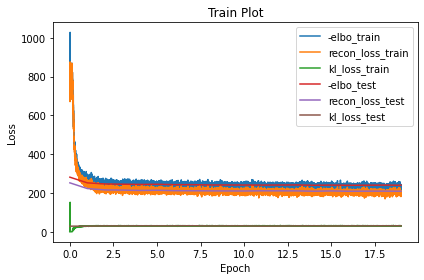

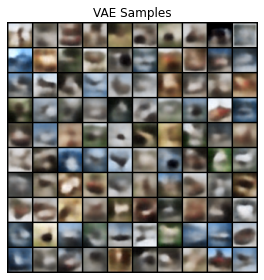

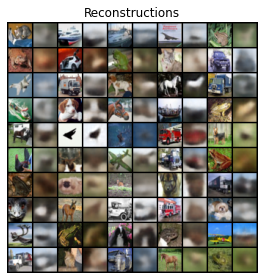

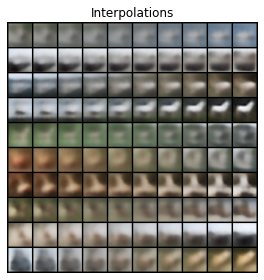

In [ ]:
train_losses, test_losses, samples, reconstructions, interpolations = train_vae(train_data, test_data)
samples, reconstructions, interpolations = samples.astype('float32'), reconstructions.astype('float32'), interpolations.astype('float32')
print(f'Final negative ELBO: {test_losses[-1, 0]:.4f}, Reconstruction Loss: {test_losses[-1, 1]:.4f}, '
      f'KL Loss: {test_losses[-1, 2]:.4f}')
plot_vae_training_plot(train_losses, test_losses, 'Train Plot', 'results/vae_q1_2_train_plot.png')
show_samples(samples, title='VAE Samples', fname='results/vae_q1_2_samples.png')
show_samples(reconstructions, title='Reconstructions', fname='results/vae_q1_2_reconstructions.png')
show_samples(interpolations, title='Interpolations', fname='results/vae_q1_2_interpolations.png')

## Q2: VQ-VAE

In this question, we'll build a simple VQ-VAE model, and train the model using the CIFAR10 dataset. After training VQ-VAE, we'll train a PixelCNN model to learn the prior of categorical latents. You might want to finish *pixel_cnn.ipynb* before completing this part. 

For VQ-VAE model, we'll use the following network architecture:

- Residual_block(dim):   
  batch_norm(dim)  
  ReLU  
  Conv - dim - 3 - 1 - 1  
  batch_norm(dim)  
  ReLU  
  Conv - dim - 1 - 1 - 0

- Encoder:  
  Conv - 256 - 4 - 2 - 1  
  batch_norm(256)  
  ReLU  
  Conv - 256 - 4 - 2 - 1  
  Residual_block(256)  
  Residual_block(256)  

- Decoder:   
  Residual_block(256)  
  Residual_block(256)  
  batch_norm(256)
  ReLU  
  TConv - 256 - 4 - 2 - 1  
  batch_norm(256)  
  ReLU  
  TConv - 3 - 4 - 2 - 1


For PixelCNN model, we'll use the following network architecture:

- Residual_block_pixelcnn(dim):   
  layer_norm(dim)  
  ReLU   
  MaskConv2d-B - dim // 2 - 1 - 1 - 0   
  layer_norm(dim//2)  
  ReLU   
  MaskConv2d-B - dim // 2 - 3 - 1 - 1  
  layer_norm(dim//2)  
  ReLU  
  MaskConv2d-B - dim - 1 - 1 - 0  

- PixelCNN: 
  MaskConv2d-A - 128 - 7 - 1 - 3  
  layer_norm(128)  
  ReLU   
  9 x Residual_block_pixelcnn(128)  
  layer_norm(128)  
  ReLU   
  MaskConv2d-B - 512 - 1 - 1 - 0  
  ReLU   
  MaskConv2d-B - 128 - 1 - 1 - 0  


We provide a training code in **models/vq_vae_solver.py** and a model template in **models/vq_vae_model.py**. Please follow the instructions and fill in the functions in **models/vq_vae_model.py**. 

We provide the functions for plotting and visualizing images. **You'll provide the following results.**
- For the VQ-VAE model, record the loss of the training data (per mini-batch) and testing data (per epoch).
- For the PixelCNN model, record the loss of the training data (per mini-batch) and testing data (per epoch).
- Sample 100 images using the trained model. 
- Show reconstruction image pairs using the trained VQ-VAE model. 


In [ ]:
from models.vq_vae_solver import train_vq_vae
from utils.vis import show_samples, save_training_plot

Epoch 0, loss 0.1350, recon_loss 0.0357, reg_loss 0.0993: 100%|██████████| 50000/50000 [00:30<00:00, 1613.22it/s]
Epoch 1, loss 0.1179, recon_loss 0.0339, reg_loss 0.0840:   1%|          | 256/50000 [00:00<00:31, 1576.23it/s]

Test , loss 0.1169, recon_loss 0.0340, reg_loss 0.0828


Epoch 1, loss 0.1047, recon_loss 0.0332, reg_loss 0.0715: 100%|██████████| 50000/50000 [00:31<00:00, 1586.44it/s]
Epoch 2, loss 0.0942, recon_loss 0.0301, reg_loss 0.0641:   1%|          | 256/50000 [00:00<00:30, 1624.73it/s]

Test , loss 0.0959, recon_loss 0.0310, reg_loss 0.0649


Epoch 2, loss 0.0768, recon_loss 0.0286, reg_loss 0.0481: 100%|██████████| 50000/50000 [00:30<00:00, 1618.80it/s]
Epoch 3, loss 0.0679, recon_loss 0.0275, reg_loss 0.0403:   1%|          | 256/50000 [00:00<00:30, 1623.54it/s]

Test , loss 0.0689, recon_loss 0.0273, reg_loss 0.0416


Epoch 3, loss 0.0648, recon_loss 0.0265, reg_loss 0.0383: 100%|██████████| 50000/50000 [00:30<00:00, 1615.69it/s]
Epoch 4, loss 0.0665, recon_loss 0.0257, reg_loss 0.0408:   1%|          | 256/50000 [00:00<00:31, 1596.29it/s]

Test , loss 0.0639, recon_loss 0.0255, reg_loss 0.0383


Epoch 4, loss 0.0817, recon_loss 0.0275, reg_loss 0.0543: 100%|██████████| 50000/50000 [00:31<00:00, 1609.76it/s]
Epoch 5, loss 0.0639, recon_loss 0.0253, reg_loss 0.0386:   1%|          | 256/50000 [00:00<00:31, 1555.57it/s]

Test , loss 0.0640, recon_loss 0.0255, reg_loss 0.0385


Epoch 5, loss 0.0631, recon_loss 0.0256, reg_loss 0.0374: 100%|██████████| 50000/50000 [00:31<00:00, 1612.81it/s]
Epoch 6, loss 0.0641, recon_loss 0.0258, reg_loss 0.0383:   1%|          | 256/50000 [00:00<00:30, 1631.41it/s]

Test , loss 0.0617, recon_loss 0.0248, reg_loss 0.0370


Epoch 6, loss 0.0668, recon_loss 0.0263, reg_loss 0.0406: 100%|██████████| 50000/50000 [00:31<00:00, 1611.75it/s]
Epoch 7, loss 0.0754, recon_loss 0.0280, reg_loss 0.0474:   1%|          | 256/50000 [00:00<00:30, 1615.83it/s]

Test , loss 0.0718, recon_loss 0.0266, reg_loss 0.0452


Epoch 7, loss 0.0629, recon_loss 0.0270, reg_loss 0.0359: 100%|██████████| 50000/50000 [00:31<00:00, 1610.18it/s]
Epoch 8, loss 0.2089, recon_loss 0.0317, reg_loss 0.1772:   1%|          | 256/50000 [00:00<00:31, 1583.45it/s]

Test , loss 0.1839, recon_loss 0.0326, reg_loss 0.1514


Epoch 8, loss 0.0586, recon_loss 0.0242, reg_loss 0.0344: 100%|██████████| 50000/50000 [00:31<00:00, 1608.53it/s]
Epoch 9, loss 0.0575, recon_loss 0.0237, reg_loss 0.0337:   1%|          | 256/50000 [00:00<00:30, 1612.53it/s]

Test , loss 0.0585, recon_loss 0.0235, reg_loss 0.0350


Epoch 9, loss 0.0576, recon_loss 0.0241, reg_loss 0.0335: 100%|██████████| 50000/50000 [00:31<00:00, 1608.84it/s]
Epoch 10, loss 0.0610, recon_loss 0.0248, reg_loss 0.0362:   1%|          | 256/50000 [00:00<00:32, 1519.26it/s]

Test , loss 0.0584, recon_loss 0.0235, reg_loss 0.0349


Epoch 10, loss 0.0562, recon_loss 0.0235, reg_loss 0.0327: 100%|██████████| 50000/50000 [00:31<00:00, 1605.48it/s]
Epoch 11, loss 0.0533, recon_loss 0.0226, reg_loss 0.0306:   1%|          | 256/50000 [00:00<00:31, 1560.79it/s]

Test , loss 0.0552, recon_loss 0.0229, reg_loss 0.0323


Epoch 11, loss 0.0627, recon_loss 0.0248, reg_loss 0.0378: 100%|██████████| 50000/50000 [00:31<00:00, 1608.98it/s]
Epoch 12, loss 0.0561, recon_loss 0.0226, reg_loss 0.0335:   1%|          | 256/50000 [00:00<00:30, 1625.66it/s]

Test , loss 0.0566, recon_loss 0.0235, reg_loss 0.0331


Epoch 12, loss 0.0542, recon_loss 0.0230, reg_loss 0.0312: 100%|██████████| 50000/50000 [00:31<00:00, 1609.30it/s]
Epoch 13, loss 0.0534, recon_loss 0.0227, reg_loss 0.0307:   1%|          | 256/50000 [00:00<00:30, 1643.48it/s]

Test , loss 0.0529, recon_loss 0.0223, reg_loss 0.0306


Epoch 13, loss 0.0539, recon_loss 0.0227, reg_loss 0.0312: 100%|██████████| 50000/50000 [00:30<00:00, 1613.80it/s]
Epoch 14, loss 0.0542, recon_loss 0.0233, reg_loss 0.0309:   1%|          | 256/50000 [00:00<00:32, 1548.84it/s]

Test , loss 0.0532, recon_loss 0.0222, reg_loss 0.0310


Epoch 14, loss 0.0531, recon_loss 0.0233, reg_loss 0.0298: 100%|██████████| 50000/50000 [00:31<00:00, 1608.20it/s]
Epoch 15, loss 0.0529, recon_loss 0.0234, reg_loss 0.0295:   1%|          | 256/50000 [00:00<00:30, 1636.43it/s]

Test , loss 0.0518, recon_loss 0.0226, reg_loss 0.0292


Epoch 15, loss 0.0754, recon_loss 0.0264, reg_loss 0.0490: 100%|██████████| 50000/50000 [00:31<00:00, 1611.65it/s]
Epoch 16, loss 0.0585, recon_loss 0.0253, reg_loss 0.0332:   1%|          | 256/50000 [00:00<00:30, 1628.12it/s]

Test , loss 0.0596, recon_loss 0.0244, reg_loss 0.0352


Epoch 16, loss 0.0498, recon_loss 0.0224, reg_loss 0.0274: 100%|██████████| 50000/50000 [00:31<00:00, 1610.36it/s]
Epoch 17, loss 0.0481, recon_loss 0.0216, reg_loss 0.0265:   1%|          | 256/50000 [00:00<00:30, 1638.36it/s]

Test , loss 0.0490, recon_loss 0.0220, reg_loss 0.0270


Epoch 17, loss 0.0497, recon_loss 0.0225, reg_loss 0.0272: 100%|██████████| 50000/50000 [00:31<00:00, 1612.15it/s]
Epoch 18, loss 0.0503, recon_loss 0.0222, reg_loss 0.0281:   1%|          | 256/50000 [00:00<00:31, 1580.80it/s]

Test , loss 0.0492, recon_loss 0.0217, reg_loss 0.0275


Epoch 18, loss 0.0510, recon_loss 0.0232, reg_loss 0.0278: 100%|██████████| 50000/50000 [00:30<00:00, 1614.92it/s]
Epoch 19, loss 0.0492, recon_loss 0.0222, reg_loss 0.0270:   1%|          | 256/50000 [00:00<00:31, 1597.11it/s]

Test , loss 0.0491, recon_loss 0.0222, reg_loss 0.0270


Epoch 19, loss 0.0487, recon_loss 0.0226, reg_loss 0.0261: 100%|██████████| 50000/50000 [00:31<00:00, 1611.68it/s]


Test , loss 0.0466, recon_loss 0.0216, reg_loss 0.0250


Epoch 1, loss 2.9056:   1%|          | 256/50000 [00:00<00:23, 2080.83it/s]

Test , loss 2.9398


Epoch 2, loss 2.8885:   1%|          | 256/50000 [00:00<00:25, 1946.95it/s]

Test , loss 2.8983


Epoch 3, loss 2.8548:   1%|          | 256/50000 [00:00<00:24, 2058.86it/s]

Test , loss 2.8820


Epoch 4, loss 2.7991:   1%|          | 256/50000 [00:00<00:24, 2035.13it/s]

Test , loss 2.8702


Epoch 5, loss 2.8717:   1%|          | 256/50000 [00:00<00:25, 1917.47it/s]

Test , loss 2.8636


Epoch 6, loss 2.7685:   1%|          | 256/50000 [00:00<00:24, 2024.90it/s]

Test , loss 2.8642


Epoch 7, loss 2.8147:   1%|          | 256/50000 [00:00<00:24, 2015.05it/s]

Test , loss 2.8618


Epoch 8, loss 2.7597:   1%|          | 256/50000 [00:00<00:26, 1896.61it/s]

Test , loss 2.8595


Epoch 9, loss 2.7863:   1%|          | 256/50000 [00:00<00:25, 1934.20it/s]

Test , loss 2.8568


Epoch 10, loss 2.7862:   1%|          | 256/50000 [00:00<00:27, 1836.29it/s]

Test , loss 2.8592


Epoch 11, loss 2.7426:   1%|          | 256/50000 [00:00<00:25, 1931.83it/s]

Test , loss 2.8613


Epoch 12, loss 2.7662:   1%|          | 256/50000 [00:00<00:24, 2028.47it/s]

Test , loss 2.8642


Epoch 13, loss 2.7389:   1%|          | 256/50000 [00:00<00:24, 2029.30it/s]

Test , loss 2.8663


Epoch 14, loss 2.7443:   1%|          | 256/50000 [00:00<00:25, 1926.40it/s]

Test , loss 2.8680


Epoch 14, loss 2.7625: 100%|██████████| 50000/50000 [00:24<00:00, 2017.11it/s]


Test , loss 2.8707
VQ-VAE Final Test Loss: 0.0466
PixelCNN Prior Final Test Loss: 2.8707


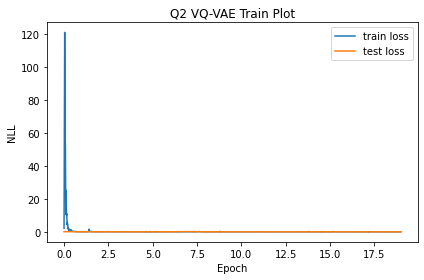

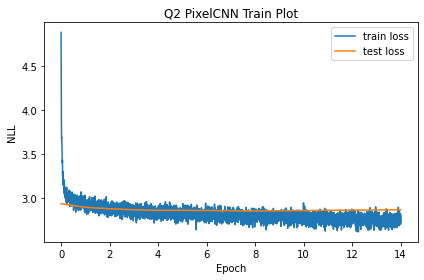

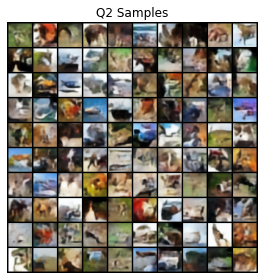

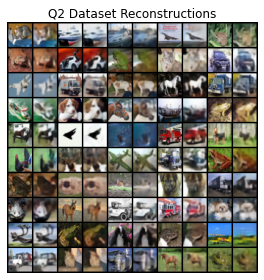

In [ ]:
vqvae_train_losses, vqvae_test_losses, pixelcnn_train_losses, pixelcnn_test_losses, samples, reconstructions = train_vq_vae(train_data, test_data)
samples, reconstructions = samples.astype('float32'), reconstructions.astype('float32')
print(f'VQ-VAE Final Test Loss: {vqvae_test_losses[-1]:.4f}')
print(f'PixelCNN Prior Final Test Loss: {pixelcnn_test_losses[-1]:.4f}')

save_training_plot(vqvae_train_losses, vqvae_test_losses,'Q2 VQ-VAE Train Plot',
                    'results/q2_vqvae_train_plot.png')
save_training_plot(pixelcnn_train_losses, pixelcnn_test_losses,'Q2 PixelCNN Train Plot',
                    'results/q2_vqvae_pixelcnn_train_plot.png')
show_samples(samples.transpose(0, 3, 1, 2), title='Q2 Samples',
              fname='results/q2_vqvae_samples.png')
show_samples(reconstructions.transpose(0, 3, 1, 2), title='Q2 Dataset Reconstructions',
              fname='results/q2_vqvae_reconstructions.png')
